In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc
from matplotlib.patches import Circle
from importlib import reload
reload(misc)

# data_dir = Path('C:/Users/Kian/Documents/data-files/disk-processing')
# data_dir = Path('/users/kianmilani/Documents/data-files/disk-processing')
data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf = 256                   # output image dimension (must be power of 2)
psf_pixelscale_lamD = 0.1    # output sampling in lam0/D
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

polaxis = 10

ndisk = 100
disk_pixelscale_mas = 20.8*u.mas/u.pix
disk_pixelscale_lamD = (disk_pixelscale_mas/mas_per_lamD).value

band1_wavelength = 575e-9*u.m
iwa_band1 = 2.8
owa_band1 = 9.7

iwa = iwa_band1 * wavelength_c/band1_wavelength
owa = owa_band1 * wavelength_c/band1_wavelength

iwa_mas = iwa*mas_per_lamD
owa_mas = owa*mas_per_lamD

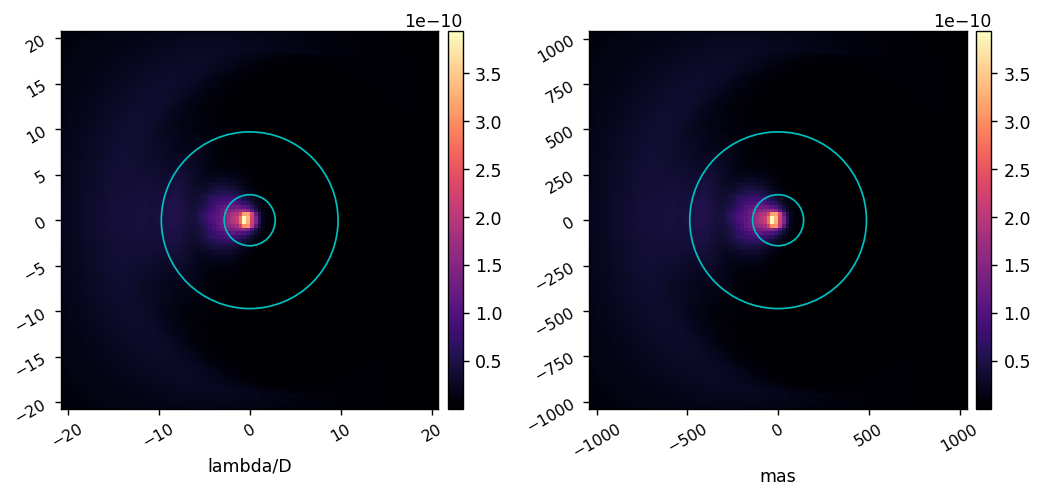

In [2]:
disk_fpath = data_dir/'disks'/'I_0_eps_eri.fits'

disk = misc.pad_or_crop(fits.getdata(disk_fpath), ndisk)
disk_hdr = fits.getheader(disk_fpath)

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk, disk, lognorm1=False, lognorm2=False, 
               pxscl1=disk_pixelscale_lamD, pxscl2=disk_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )


# Do the matrix multiplication

In [3]:
ipsf_fpath = data_dir/'ipsfs'/'ipsf_matrix_band1_polaxis{:d}_rtheta_2.hdf5'.format(polaxis)
f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

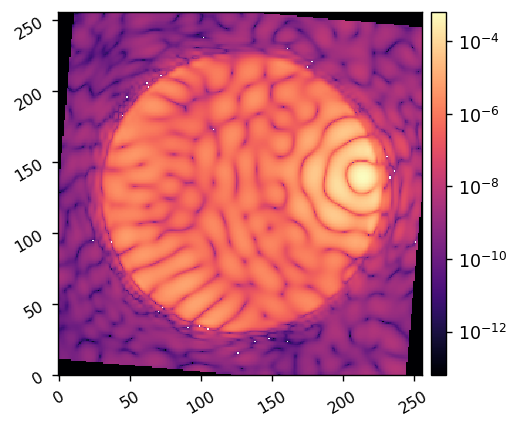

In [12]:
ipsf_matrix.shape
misc.myimshow(ipsf_matrix[:,5270].reshape(npsf,npsf), lognorm=True)

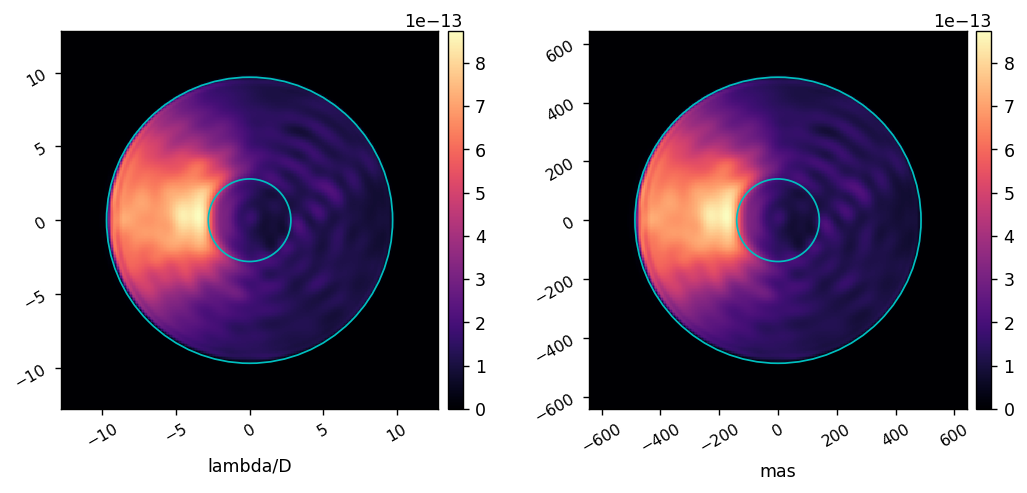

In [13]:
disk_sim = np.reshape(ipsf_matrix.dot(disk.flatten()), (npsf,npsf))

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk_sim, disk_sim, lognorm1=False, lognorm2=False, 
               pxscl1=psf_pixelscale_lamD, pxscl2=psf_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )